<H1><center>E-commerce Customer Churn Analysis
<br>--------

By : Fathur Rizky Maulana

-------------------------

### **Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

### `Initial Setup`

In [1]:
# Import library eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Membuat grafik
import seaborn as sns #Membuat grafik
import missingno as msno #Cek missing value
import phik #Cek phik korelasi
from sklearn.experimental import enable_iterative_imputer #Melakukan imputasi
from sklearn.impute import IterativeImputer #Melakukan iterative imputasi

# Import library sklearn
from sklearn.model_selection import train_test_split #Membagi data train dan data test
from pycaret.classification import * #Men-setting parameter dasar menggunakan pycaret
from sklearn.base import BaseEstimator, TransformerMixin #Membuat estimator
from sklearn.preprocessing import FunctionTransformer #Meneruskan argumen objek fungsi dan mengembalikan hasil dari fungsi ini

# Import library uji statistics
from scipy.stats import ks_2samp # Uji KS untuk melihat distorsi sebelum dan sesudah handling outlier

# Import library modeling
import pycaret
from pycaret.internal.preprocess.transformers import TransformerWrapper

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

import warnings
warnings.filterwarnings('ignore')


import matplotlib
min_val, max_val = 0, 0.8
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
custom_summer = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

### `Business Problem Understanding`

**Context**

Perusahaan *startup e-commerce* terkemuka di Indonesia yang bernama **Ecompedia** memiliki masalah pada bisnis yang dijalankan-nya, pada Ecompedia terdapat beberapa pelanggan yang sudah tidak lagi menjadi pelanggan atau tidak lagi berbelanja di Ecompedia atau yang biasa disebut dengan istilah ***Churn*** (`Pelanggan Tidak Loyal`). Ecompedia saat ini memiliki ***churn rate*** yang cukup tinggi, yaitu sebesar 16,33% dari total pelanggan [(perhitungan *Churn Rate*)](https://www.paddle.com/resources/calculate-churn-rate), dimana nilai ideal untuk ***churn rate*** pada *e-commerce* saat ini hanya berkisar 5% sampai 7% per tahun [(Monique Danao,2023)](https://www.forbes.com/advisor/business/churn-rate/). Oleh karena itu, hal tersebut akan berdampak pada jumlah pendapatan yang diterima oleh Ecompedia, karena *churn rate* yang tinggi akan diikuti dengan penurunan pendapatan perusahaan.

Di sisi lain, ketika perusahaan salah memprediksi label ***Churn*** atau **tidak *Churn*** kepada pelanggan, hal tersebut akan memberikan masalah kepada perusahaan. Contohnya, jika perusahaan akan melakukan usaha marketing ke semua pelanggan, maka besaran biaya yang dikeluarkan akan menjadi tinggi. Adapun jika perusahaan hanya memberikan usaha marketing ke sebagian pelanggan, maka perusahaan bisa kehilangan pelanggan yang sebenarnya berpotensi menjadi pelanggan yang **tidak *Churn*** (`Loyal`).

**Problem Statement**

Bagaimana perusahaan dapat memprediksi dan memanfaatkan risiko *churn* dari setiap pelanggan agar promo, diskon, iklan dan usaha marketing lainnya dialokasikan secara lebih efisien sehingga profit dari penjualan barang di Ecompedia meningkat?

**Project Stakeholders:**

Pihak stakeholders yang terlibat dan yang akan menggunakan model dari analisis ini adalah:
* ***Sales & Marketing Team***: Tim ini akan bertanggung jawab dalam mengembangkan dan merencanakan usaha marketing serta mengimplementasikan kepada pelanggan secara tepat dalam upaya memaksimalkan pendapatan perusahaan.
* ***Operations Team***: Tim ini akan bertanggung jawab dalam mengkoordinasikan serta mengurus rincian operasi, mengevaluasi gambaran besar operasi, dan memastikan bahwa area bisnis berjalan semulus dan seefektif mungkin.
* ***Finance Team***: Tim ini akan bertanggung jawab dalam mengatur keuangan perusahaan yang diakibatkan oleh usaha marketing.

Ketiga peran diatas memiliki tujuan yang sama yaitu memaksimalkan pendapatan perusahaan dengan tepat

**Goals**

*Stakeholders* dapat mengetahui serta memprediksi karakteristik dari jenis pelanggan yang ***Churn*** dan yang **Tidak *Churn***, sehingga mereka dapat menerapkan usaha marketing dengan tepat sasaran. Hal ini dapat menurunkan biaya yang diakibatkan oleh usaha marketing tersebut dan diharapkan juga dapat meningkatkan profit dengan mempertahankan pelanggan yang loyal terhadap **Ecompedia**.

**Analytic Approach**

Metode dalam melakukan analisis *customer churn* ini menggunakan **analisis prediktif**, kemudian membangun model **`klasifikasi`** yang akan membantu *stakeholders* untuk dapat memprediksi jenis pelanggan *Churn* (tidak loyal) dan Tidak *Churn* (loyal) berdasarkan data historis.

**Metric Evaluation**

Karena kita akan memfokuskan pengguna yang ***churn*** (**`Tidak Loyal`**), maka target yang kita tetapkan adalah sebagai berikut:

**Target**:   
`0` : Pengguna tidak *churn* (`Loyal`) Negative
<br>
`1` : Pengguna *churn* (`Tidak Loyal`) Positive

**Metric Evaluation**:

|                   | Not Churn-Pred | Churn-Pred |
| ----------------- | -------------- | ---------- |
| **Not Churn-Act** |       TN       |     FP     |
| **Churn-Act**     |       FN       |     TP     |

**`Type 1 Error`** : **False Positive**
<br>
`Interpretasi`: Pengguna yang seharusnya tidak *churn* (**Loyal**), tapi hasil prediksi-nya sebagai pengguna *churn* (**Tidak loyal**) 
<br>
`Konsekuensi`: Kehilangan potensi pendapatan dari pengguna yang sebenarnya tidak *churn* (**Loyal**).

**`Type 2 Error`** : **False Negative**
<br>
`Interpretasi`: Pengguna yang seharusnya *churn* (**Tidak Loyal**), tapi hasil prediksi-nya sebagai pengguna tidak *churn* (**loyal**)
<br>
`Konsekuensi`: Kerugian dari biaya marketing yang dikeluarkan untuk pelanggan yang sebenarnya *churn* (**Tidak Loyal**).

Untuk memberikan gambaran konsekuensi secara kuantitatif, maka kita akan coba simulasikan perhitungan biaya yang akan berdampak kepada perusahaan berdasarkan asumsi berikut:
* Rata-rata biaya biaya marketing untuk *e-commere* 
* Total pendapatan *market place e-commerce* di Indonesia: Rp 
* Jumlah Pengguna *e-commerce* di Indonesia tahun 2022: 178.94 juta

Berdasarkan asumsi diatas, maka kita dapat mencoba melakukan perhitungan konsekuensi-nya sebagai berikut:
* Hilangnya potensi pendapatan dari pengguna yang berpotensi loyal => 
* Hilangnya biaya marketing untuk promo-promo =>

Berdasarkan konsekuensi diatas, langkah yang tepat untuk pemilihan model adalah model yang **mengurangi jumlah hilangnya pelanggan loyal**. Jadi kita ingin sebanyak mungkin memprediksi `kelas Positif` yang benar Positif, dan sesedikit mungkin prediksi `False Negative`. Jadi metric utama yang akan digunakan adalah Recall,

### `Data Understanding`

Dataset dan deskripsi dapat di akses pada link berikut:
<br>
[E-commerce Customer Churn](https://drive.google.com/drive/folders/1PITb78NtK9Ra6wOkQdXCIgItZkj29Ves)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `Tenure` | Masa tenure pelanggan (`bulan`) |
| `WarehouseToHome` | Jarak antara warehouse ke rumah pelanggan (`mil`) |
| `NumberOfDeviceRegistered` | Jumlah perangkat yang terdaftar (`unit`) |
| `PreferedOrderCat` | Kategori yang disukai pelanggan bulan lalu |
| `SatisfactionScore` | Skor kepuasan pelanggan terhadap service |
| `MaritalStatus` | Status pernikahan pelanggan |
| `NumberOfAddress` | Jumlah alamat yang terdaftar |
| `Complain` | Adakah complain dalam satu bulan terakhir |
| `DaySinceLastOrder` | Hari sejak pemesanan terakhir (`hari`) |
| `CashbackAmount` | Rata-rata cashback bulan lalu (`$`) |
| `Churn` | Status churn pelanggan |

**`Complain`** == `0` : Tidak Ada *complain*, `1` : ada *complain*
<br>
**`Churn`** == `0` : Tidak *churn*, `1` : *Churn*

In [2]:
# Import file CSV

df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-3\data\\raw\data_ecommerce_customer_churn.csv")
print(f'Jumlah baris dan kolom: {df.shape}')

df.sample(5)

Jumlah baris dan kolom: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
266,10.0,18.0,5,Laptop & Accessory,1,Married,6,0,1.0,191.52,0
3506,11.0,17.0,4,Mobile Phone,4,Married,3,0,8.0,164.36,0
1151,9.0,15.0,4,Mobile Phone,3,Single,3,0,5.0,168.23,0
1327,NaN,13.0,3,Mobile,5,Single,4,1,3.0,121.66,1
779,1.0,12.0,2,Mobile Phone,4,Married,3,1,3.0,148.28,0


#### **Initial Assessment**

In [3]:
# Check karakteristik dataset

pd.DataFrame(
        {
        'feature': df.columns.values,
        'data_type': df.dtypes.values,
        'total_row': df.isna().count().values,
        'total_null': df.isna().sum().values,
        '%null_value': df.isna().mean().values * 100,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns]
        }
    )

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,Tenure,float64,3941,194,4.922608,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,3941,169,4.288252,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,3941,0,0.000000,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,3941,0,0.000000,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,3941,0,0.000000,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,3941,0,0.000000,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,3941,0,0.000000,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,3941,0,0.000000,2,"[0, 1]"
8,DaySinceLastOrder,float64,3941,213,5.404720,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,3941,0,0.000000,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


__Insight :__
<br>

**1. Numerical Variable:**
- `Discrete` : NumberOfDeviceRegistered, NumberOfAddress
- `Continue` : Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount
<br>

**2. Categorical variable:**
- `Nominal` : PreferedOrderCat, MaritalStatus, Complain, **Churn**
- `Ordinal` : SatisfactionScore

**3. `Target`: Churn**

**4. Terdapat total 3.941 jumlah baris pada dataset**

**5. Tipe data untuk setiap variabel sudah sesuai**

**6. Terdapat missing value pada kolom "Tenure" 194 (4.92%), "WarehouseToHome" 169 (4.29%), dan "DaySinceLastOrder" 213 (5.40%)**

#### **Numerical variable**

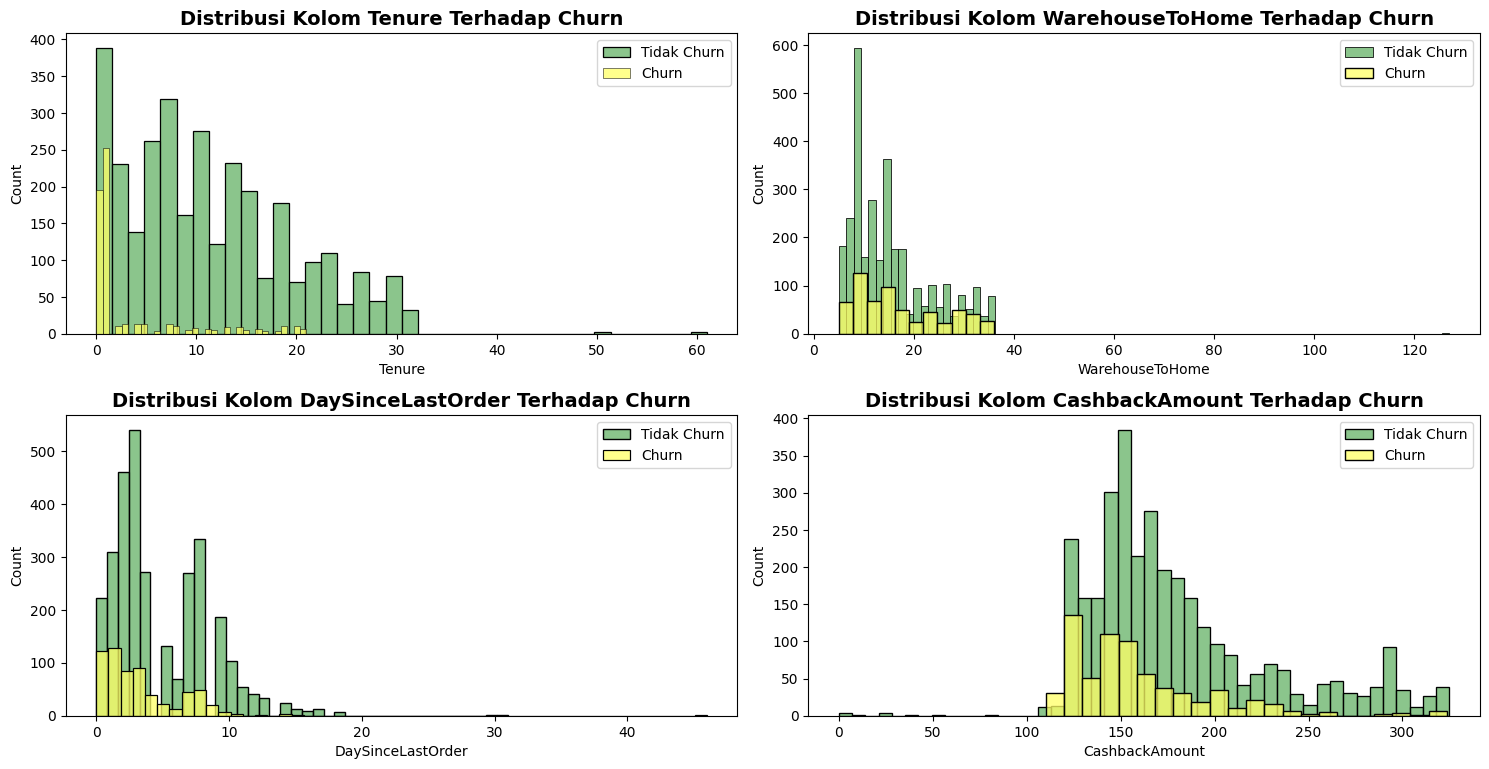

In [11]:
# Cek variabel numerik kontinu

kontinu = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in kontinu:
    plt.subplot(4,2,a)
    sns.histplot(x=df[df["Churn"]==0][i],color=cmap([100]))
    sns.histplot(x=df[df["Churn"]==1][i],color=cmap([350]))
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.title(f"Distribusi Kolom {i} Terhadap Churn", fontsize=14, weight='bold')
    a+=1

plt.show()

__Insight :__
* Pada kolom ***Tenure***, pelanggan churn terjadi pada awal bulan pemakaian yaitu di bulan ke-0 hingga bulan ke-2. Hal tersebut kemungkinan bisa terjadi dikarenakan pelanggan masih beradaptasi dengan platform e-commerce dan merasa tidak cocok dengan platform tersebut
* Pada kolom ***WarehouseToHome***, pelanggan dengan jarak gudang ke rumah kurang dari 20 mil cenderung churn. Hal tersebut mungkin dikarenakan ongkos kirim yang terlalu mahal untuk jarak yang dekat dengan rumah
* Pada kolom ***DaySinceLastOrder***, pelanggan terbanyak churn terjadi satu sampai dua hari setelah melakukan order. Hal tersebut mungkin terjadi dikarenakan pelanggan hanya membutuhkan barang dari e-commerce dan tidak tertarik dengan platform e-commerce tersebut
* Pada kolom ***CashbackAmount*** (nilai dibawah 100 dolar kemungkinan adalah nilai outlier), semakin rendah cashback yang diberikan maka semakin banyak pelanggan yang churn

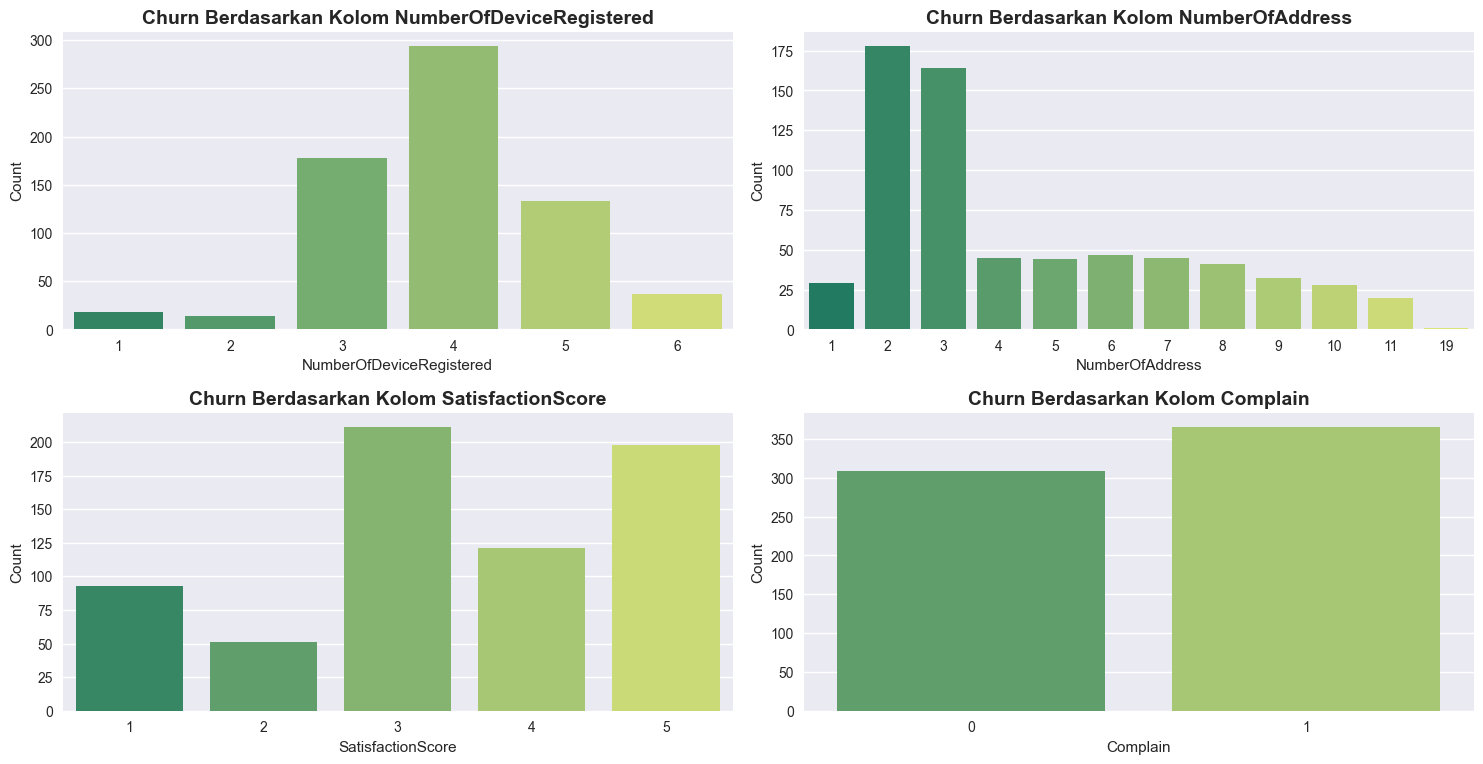

In [6]:
# Cek variabel numerikal diskrit dan kategorikal ordinal

diskritOrdinal = ["NumberOfDeviceRegistered", "NumberOfAddress", "SatisfactionScore", "Complain"]

plt.figure(figsize=(15,15))

a=1
for i in diskritOrdinal:  
    plt.subplot(4,2,a)
    plt.style.use("seaborn")
    sns.countplot(x=df[df["Churn"]==1][i], palette="summer")
    plt.title(f"Churn Berdasarkan Kolom {i}", fontsize=14, weight="bold")
    plt.ylabel("Count")
    a+=1
    plt.tight_layout()

plt.show()

__Insight :__
* Pada kolom ***NumberOfDeviceRegistered***, pelanggan dengan jumlah device lebih dari 2 cenderung akan churn. Hal ini mungkin karena pelanggan memiliki banyak opsi e-commerce dan pelanggan tersebut dapat berpindah-pindah e-commerce
* Pada kolom ***NumberOfAddress***, pelanggan yang memiliki jumlah address 2 dan 3 akan cenderung churn
* Pada kolom ***SatisfactionScore***, pelanggan yang memilih 3 dan 5 di SatisfactionScore cenderung churn
* Pada kolom ***Complain***, pelanggan yang melakukan complain cenderung akan churn

#### **Categorical variable**

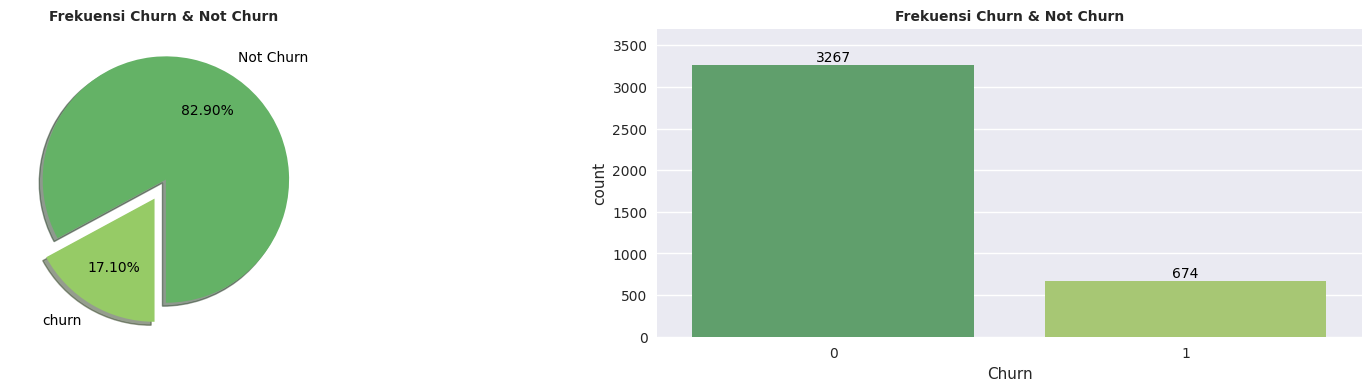

In [7]:
# Melihat kategori Churn

# Mengatur proporsi grafik
fig, axes = plt.subplots(1, 2, figsize=(20,4))
plt.style.use('default')
cmap = plt.get_cmap('summer')

# create pie chart
temp_df = df.Churn.value_counts(normalize=True) * 100
axes[0].pie(x=[temp_df.loc[0], temp_df.loc[1]], labels=['Not Churn', 'churn'], colors=cmap([100, 150]), autopct='%0.2f%%', 
        startangle=270, pctdistance=0.65, labeldistance=1.15, explode=(0.03, 0.15), shadow=True)
# set title
axes[0].set_title('Frekuensi Churn & Not Churn', fontsize=10, weight='bold')

# create barplot
plt.title("Frekuensi Churn & Not Churn", fontsize=10, weight='bold')
# set title dan 
ax = sns.countplot(data=df, x="Churn", palette="summer")
ax.set_ylim([0, 3700])
# annotation
ax.bar_label(ax.containers[0])

plt.show();

__Insight :__
* Jumlah pengguna yang ***Churn*** (`Tidak Loyal`) sebanyak 2736 (83.67%)
* Jumlah pengguna yang **Tidak *Churn*** (`Loyal`) sebanyak 534 (16.33%)
* Dari dataset terjadi ***Imbalance***, maka kita akan lakukan analisis mendalam pada preprocessing

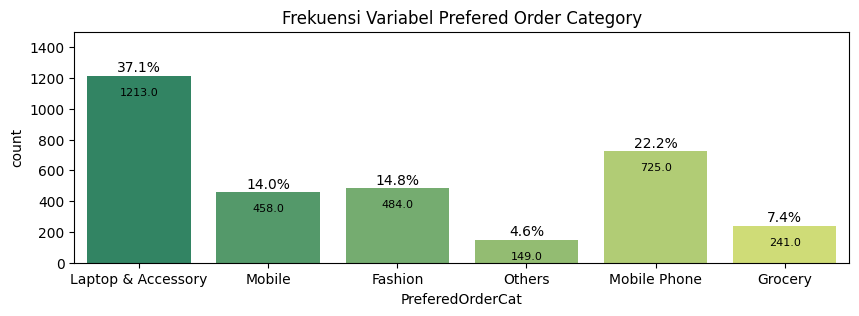

In [ ]:
# Cek Categorical Variabel fo Prefered Order Category Feature

plt.style.use("default")
plt.subplots(figsize=(10, 3))
plt.title("Frekuensi Variabel Prefered Order Category")
ax = sns.countplot(data=df, x="PreferedOrderCat", palette="summer")
ax.set_ylim([0, 1500])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center',
                   size=8,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.show()

__Insight :__
* Kategori "*Mobile*" dan "*Mobile Phone*" bisa memiliki arti yang sama. Kita bisa memasukan kedua kategori tersebut menjadi 1 kategori "***Mobile Phone***"
* Pada grafik tersebut kategori pembelian terbanyak adalah *Mobile* dan *Mobile Phone* dengan total pembelian sebesar 1.183 (36.2%)
* *E-commerce* Ecompedia didominasi olah pelanggan yang membeli barang elektronik (*Laptop & Accesorry* serta *Mobile Phone*). Hal ini menandakan bahwa kategori tersebut adalah kategori barang favorit di Ecompedia

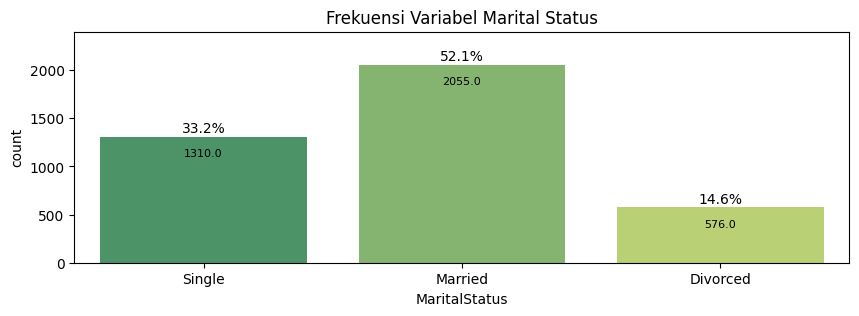

In [ ]:
# Cek Categorical Variabel fo Marital Status Feature

plt.style.use("default")
plt.subplots(figsize=(10, 3))
plt.title("Frekuensi Variabel Marital Status")
ax = sns.countplot(data=df, x="MaritalStatus", palette="summer")
ax.set_ylim([0, 2400])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center',
                   size=8,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.show()

__Insight :__
* Pengguna *e-commerce* terbanyak pada variabel *Marital Status* adalah kategori ***Married*** sebesar 1.686 (51.6%)
* Pengguna *e-commerce* terbanyak kedua adalah ***Single*** sebesar 1.008 (30.8%)
* Dan ***Divorced*** adalah kategori terendah untuk pengguna *e-commerce* sebesar 576 (17.6%)

### `Data Preparation`

In [ ]:
# find the lower bound and upper bound variable

def CheckBound(x):
    Q1 = int(x.quantile([0.25]).values)
    Q3 = int(x.quantile([0.75]).values)
    IQR = Q3-Q1
    LowerBound = Q1-1.5*IQR
    UpperBound = Q3+1.5*IQR
    total = len(df[(x<LowerBound) | (x>UpperBound)])

    result = f'''
        Lower Bound is: {LowerBound}
        Upper Bound is: {UpperBound}
        Total Outlier is: {total}'''
    
    return result

#### **Finding Problematic Data**

##### **Data Duplikat dan Typo**, Deteksi dan kuantifikasi data duplikat dan kesalahan ketik:

**Data Duplikat**

In [18]:
# Cek Data Duplikat

nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%')

Jumlah Data Duplikat: 0
Persentase Data Duplikat: 0.0%


__Insight:__
* Terdapat 671 data duplikat dari 3.941 baris data dengan persentase sebesar 17.03%
* Dari dataset yang disajikan tidak memiliki variabel tipe "**ID Data**", sehingga data duplikat dapat dianggap benar-benar duplikat
* Solution : Drop data duplikat tersebut

**Data typo**

In [ ]:
# Cek data typo untuk categorical variable

CategoryVar = ["PreferedOrderCat", "MaritalStatus"]
for i in CategoryVar:
    uniqueValue = df[i].unique()
    print(f"Feature {i}: {uniqueValue}")

Feature PreferedOrderCat: ['Laptop & Accessory' 'Mobile' 'Fashion' 'Others' 'Mobile Phone' 'Grocery']
Feature MaritalStatus: ['Single' 'Married' 'Divorced']


__Insight:__
* Pada feature ***PreferedOrderCat*** terdapat kategori "**Mobile**" dan "**Mobile Phone**"
* `Solution` : Ubah kategori "Mobile" menjadi kategori "Mobile Phone"
* Pada feature ***MaritalStatus*** tidak terdapat data typo

**Handling data duplikat**:

In [20]:
# Handling data duplicate

df.drop_duplicates(inplace=True)
nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)

print(f"*** Handling data duplikat sudah dilakukan ***\n\nJumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%")

*** Handling data duplikat sudah dilakukan ***

Jumlah Data Duplikat: 0
Persentase Data Duplikat: 0.0%


**Handling Data Typo** dilakukan di preprocessing pada setup pycaret (Karena kita ingin ketika data baru dimasukan ke model ML ini kategori "Mobile" pada kolom "PreferedOrderCat" langsung dikenali sebagai kategori "Mobile Phone")

##### **Missing Value**, Deteksi dan kuantifikasi missing value:

Text(0.5, 1.0, 'Cek Missing Value')

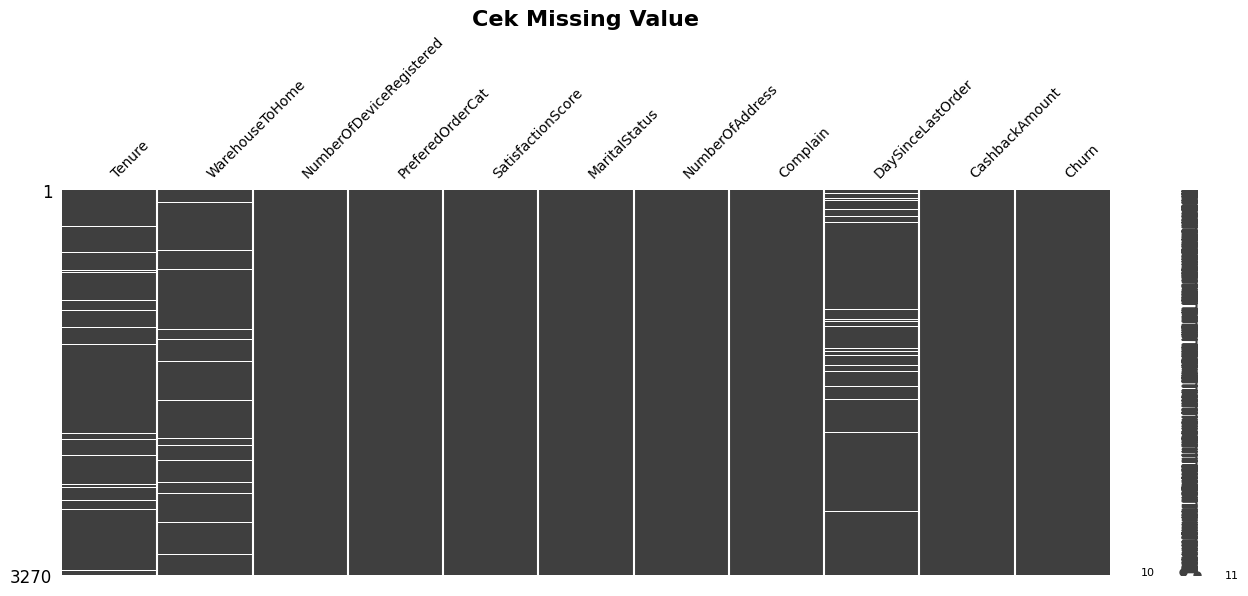

In [ ]:
# Cek missing value

msno.matrix(df, figsize=(15,5), fontsize=10)
plt.title("Cek Missing Value", fontsize=16, weight="extra bold")

In [26]:
# Cek jumlah missing value masing-masing kolom

print(df.isna().sum())

# Kalkulasi missing value
print(f'''\nJumlah total missing value: {df.isnull().sum().sum()}
Jumlah baris yang terdapat missing value: {df[df.isnull().any(axis=1)].shape[0]}
Persentase baris dengan missing value: {round(df.isnull().sum().sum()/df.shape[0]*100,2)}%''')

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

Jumlah total missing value: 476
Jumlah baris yang terdapat missing value: 476
Persentase baris dengan missing value: 14.56%


__Insight :__
* Terdapat tiga kolom missing value "***Tenure***"(160), "***WarehouseToHome***"(135), "***DaySinceLastOrder***"(182) (float64)
* Jumlah total missing value adalah 476, dan lokasi missing value di baris yang berbeda-beda (476 baris), dengan presentase missing value 14.56% dari total data tersedia
* Kita tidak bisa lakukan drop missing value (karena jumlah missing value yang cukup besar 14.56%)
* Missing value tidak menunjukan pola tertentu/ acak (**MAR**)
* Perlu analisis lebih lanjut mengenai handling missing value

interval columns not set, guessing: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'Churn']
interval columns not set, guessing: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'Churn']


Text(0.5, 1.0, 'Significance matrix')

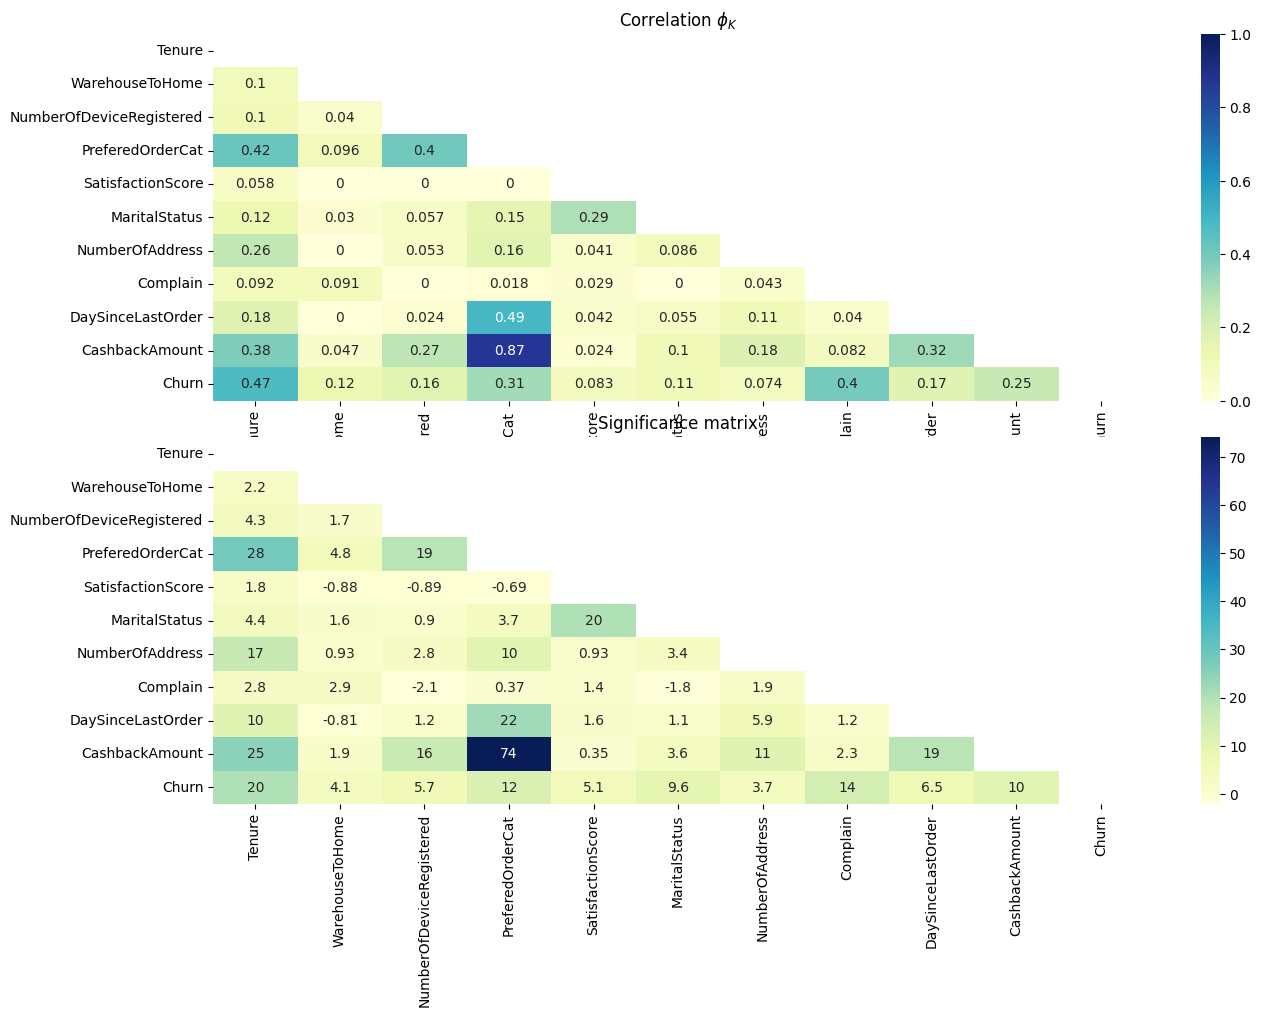

In [ ]:
# Cek corelations matrix untuk kolom "Tenure", "WarehouseToHome", "DaySinceLastOrder"

plt.style.use('default')

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

cols = df.columns
corr = df[cols].phik_matrix()
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlGnBu", ax=ax[0])

sig = df[cols].significance_matrix()
sig_mask = np.triu(np.ones_like(sig, dtype=bool))
sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlGnBu", ax=ax[1])

ax[0].set_title(f"Correlation $\phi_K$")
ax[1].set_title(f"Significance matrix")



__Insight :__
* Dari 3 kolom yang memiliki mising value ("***Tenure***", "***WarehouseToHome***", "***DaySinceLastOrder***"), tidak ada yang berkorelasi signifikan dengan feature lainnya
* Solution : Lakukan imputasi menggunakan metode **`Multivariate Imputation`**/ **`Iterative Imputer`**

**Handling missing value** dilakukan di preprocessing setup pycaret

##### **Outlier,** Deteksi dan kuantifikasi outlier:

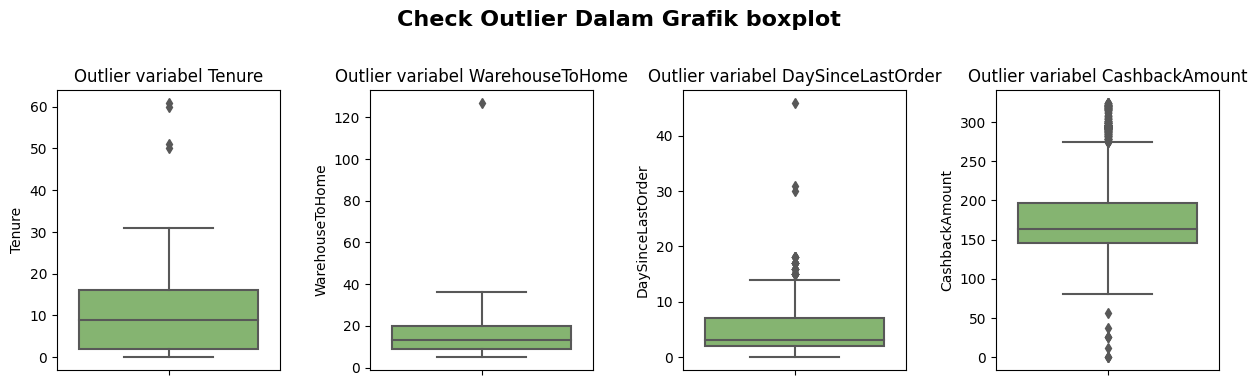

In [ ]:
# Cek data outlier untuk continue variable (Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount)

contVar = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.style.use("default")
ax = plt.figure(figsize=(15, 8))
for i in range(0, len(contVar)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[contVar[i]], palette="summer")
    plt.title(f"Outlier variabel {contVar[i]}", fontsize=12, ha="center")

ax.suptitle("Check Outlier Dalam Grafik boxplot", fontsize=16, weight="extra bold")
ax.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4)
plt.show()

In [ ]:
# Melihat lower bound, upper bound, outlier, dan persentase outlier
for i in range(0, len(contVar)):
    Q1 = df[contVar[i]].quantile(0.25)
    Q3 = df[contVar[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    condition = (df[contVar[i]]< lower_bound) | (df[contVar[i]]> upper_bound)
    outlier = df.loc[condition, contVar[i]].count()
    PersentaseOutlier = outlier/df[contVar[i]].count()*100
    print(f"{contVar[i]}\nLower Bound   : {round(lower_bound,2)}\nUpper Bound   : {round(upper_bound,2)}\nJumlah Outlier: {outlier} ({round(PersentaseOutlier,2)}%)\n")

Tenure
Lower Bound   : -19.0
Upper Bound   : 37.0
Jumlah Outlier: 4 (0.13%)

WarehouseToHome
Lower Bound   : -7.5
Upper Bound   : 36.5
Jumlah Outlier: 1 (0.03%)

DaySinceLastOrder
Lower Bound   : -5.5
Upper Bound   : 14.5
Jumlah Outlier: 40 (1.29%)

CashbackAmount
Lower Bound   : 69.02
Upper Bound   : 274.0
Jumlah Outlier: 253 (7.74%)



__Insight :__
* Jumlah outlier pada kolom "***Tenure***" dan "***WarehouseToHome***" kecil yaitu 4 dan 1 baris. Solusi drop kolom
* Outlier pada kolom "***DaySinceLastOrder***" dan "***CashbackAmount***" bisa diabaikan karena sebagai nilai yang wajar apabila memiliki nilai variansi yang tinggi
* Outlier pada kolom "***DaySinceLastOrder***" dan "***CashbackAmount***" akan diproses pada bagian preprocessing

**Handling outlier** dilakukan di preprocessing setup pycaret

##### **Rare label**, Deteksi dan kuantifikasi rare value:

In [ ]:
# Cek target model

(df["Churn"].value_counts(normalize=True) * 100).sort_index()

0    83.669725
1    16.330275
Name: Churn, dtype: float64

__Insight :__
* Imbalance data, perbandingan label **non-churn** (83.64%) lebih banyak dibanding label **churn** (16.35%)
* 

#### **Dealing with The Problem**

Bagi dataset menjadi train set dan test set:

In [ ]:
# Membagi data train set dan data test set

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((2616, 11), (654, 11))

Setting parameter dasar untuk menginisialisasi experiment dan membuat pipeline transformasi:

In [ ]:
# Bikin class untuk handling Data typo dan imputasi

class clearTypoImput(BaseEstimator, TransformerMixin):

    def _init_(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["PreferedOrderCat"].replace("Mobile", "Mobile Phone", inplace=True) #Replace kategori "Mobile" to "Mobile Phone"
        imputasi = IterativeImputer(max_iter=10, random_state=0) #Imputasi missing value
        cols = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"] #Imputasi missing value
        X[cols] = imputasi.fit_transform(X[cols]) #Imputasi missing value
        return X.to_numpy()

In [ ]:
# # Class untuk handling drop

# import pdpipe as pdp

# class handlingDrop(BaseEstimator, TransformerMixin):
    
#     def _init_(self):
#         pass

#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         # X[list(X.columns)].drop_duplicates(inplace=True) #Drop duplikat n=671
#         # X[["Tenure", "WarehouseToHome"]].drop(X[(X["Tenure"]>33) | (X["WarehouseToHome"]>36.5)].index, inplace=True) #Drop outlier n=5
#         return X.to_numpy()

In [ ]:
# Membuat pipeline transformasi

customPipeline = [
    ("clearTypoImput", TransformerWrapper(transformer=clearTypoImput()))
]

In [ ]:
# Setting parameter dasar menggunakan pycaret

clf = setup(
    # general setup
    data=df_train, 
    target="Churn",
    train_size=0.8,
    verbose=False,
    preprocess=False,

    # feature setup
    # ignore_features=[],

    # experiment setup
    session_id=42, 
    log_data=True,
    log_plots=True,

    # data wrangling
    imputation_type=None, 
    remove_outliers=None,
    # outliers_method='iforest',
    custom_pipeline=customPipeline,
    custom_pipeline_position=0,
)

Proses scaling dan encoding:

Feature Creation:

Feature Selection:

### `Modeling`

#### **Model Experiment**

Bandingkan model regresi atau klasifikasi untuk mendapatkan benchmark model:

Lakukan optimasi model benchmark:

Validasi silang 10-fold untuk mendapatkan rentang kinerja model:

**Model Intepretation**

* .....
* .....
* .....

**Model Limitation**

* .....
* .....
* .....


### `Conclusion`

Beberapa hal yang dapat disimpulkan yaitu:

* ....
* ....
* ....

### `Recommendations`

Hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

* ....
* ....
* ....